# Convert census zones to network graph

Represent census zones as a network graph to allow look up nearest neighbors of a census zone and integrate the average of nearby regions speed as features for an improved LSTM model. 

*Author: Koki Sasagawa*  
*Date: 3/20/19*

In [39]:
import networkx as nx
import geopandas as gpd
import numpy as np
import fiona
import os 
import sys
from shapely.geometry import shape 
from matplotlib import pyplot as plt

sys.path.insert(0, '../utils/')
from decorators import timer

%matplotlib inline 

In [2]:
# Specify file paths
temp_data_dir = '../../temp_data/'

In [3]:
data_files = os.listdir(temp_data_dir)

for i, j in enumerate(data_files):
    print(i, j)        

0 .DS_Store
1 test.csv
2 sfdata_mapped
3 dummy_df.csv
4 sf_filtered_census_data.shx
5 sf_filtered_census_data.shp
6 sf_filtered_census_data.cpg
7 sf_GEOID_GIS_data.shx
8 sf_GEOID_GIS_data.shp
9 sf_GEOID_GIS_data.cpg
10 test1.csv
11 sf_GEOID_GIS_data.dbf
12 region_data
13 sf_filtered_census_data.dbf
14 sfdata_clean


In [4]:
sf_census_zones = gpd.GeoDataFrame.from_file(temp_data_dir + data_files[8])
print('Size of census zones df: {}'.format(sf_census_zones.shape))
sf_census_zones.head()

Size of census zones df: (196, 2)


,geoid10,geometry
0,6075016500,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,6075016400,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,6075016300,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,6075016100,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,6075016000,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


The function below is very memory inefficient with a time complexity of $O(n)^2$
It will take a while to complete for larger GIS data

In [5]:
# Convert shapefile to networkx graph
@timer
def create_graph(file):
    """Accept GIS file and returns network graph"""
    G = nx.Graph()
    i = 1
    
    for shp in file.itertuples(): 
        G.add_node(i, block=shp[2], geoid=shp[1])
        i += 1 
        
    for n in G.nodes(data=True):
        state = n[1]['block']
        for o in G.nodes(data=True):
            other = o[1]['block']
            if state != other and state.touches(other):
                G.add_edge(n[0], o[0])

    return G

In [6]:
census_graph = create_graph(sf_census_zones)

Running create_graph...
Finished in 2.8196s


In [8]:
print('Graph stats:')
print('Number of nodes: {}'.format(census_graph.number_of_nodes()))
print('Number of edges: {}'.format(census_graph.number_of_edges()))

Graph stats:
Number of nodes: 196
Number of edges: 612


In [47]:
degrees = census_graph.degree() #Dict with Node ID, Degree
nodes = census_graph.nodes()
n_color = np.asarray([degrees[n] for n in nodes])

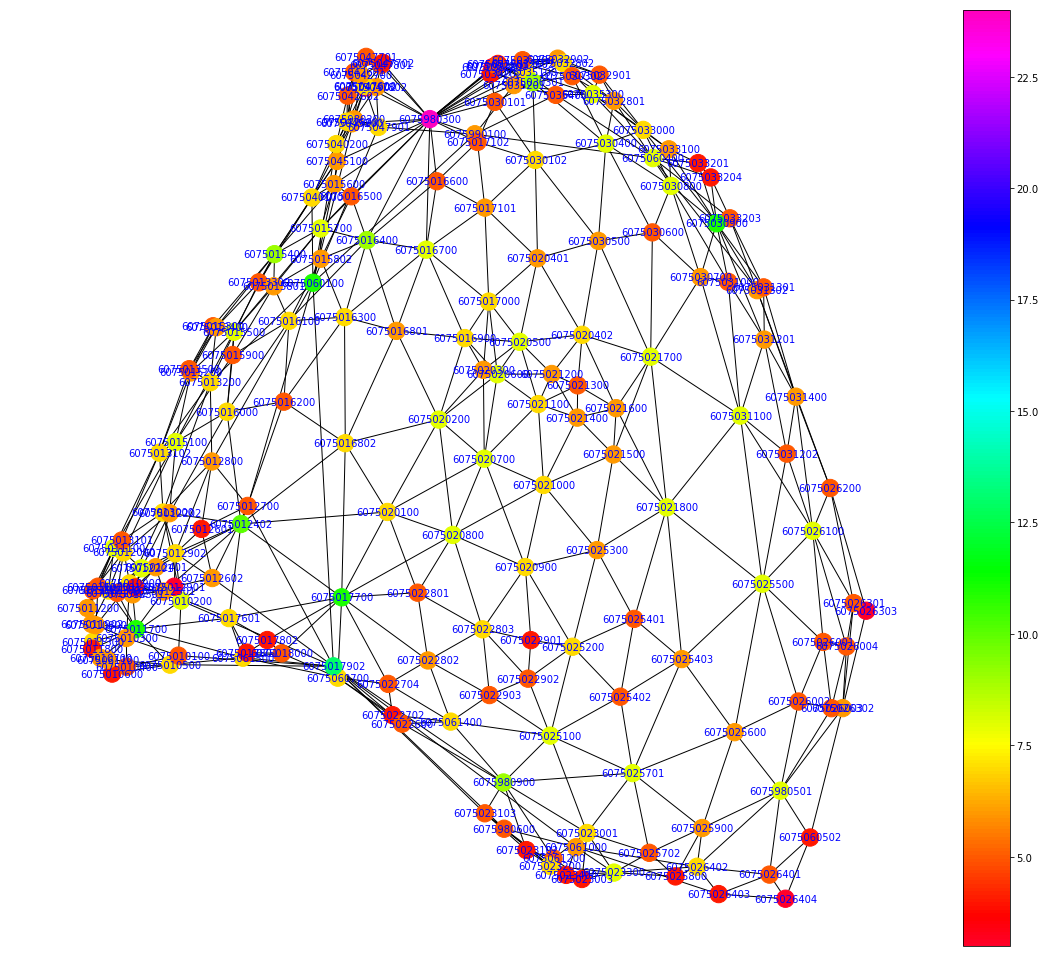

In [70]:
plt.figure(figsize=(15,13))
pos = nx.spectral_layout(census_graph)
nx.draw(census_graph, pos, node_color=n_color, cmap='gist_rainbow')
node_attr = nx.get_node_attributes(census_graph, 'geoid')
G = nx.draw_networkx_labels(census_graph, pos, labels=node_attr, font_size=10, font_color='blue')

vmin = min([n[1] for n in census_graph.degree()])
vmax = max([n[1] for n in census_graph.degree()])
cmap = plt.cm.gist_rainbow

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)

plt.savefig('../../output/census_map.png')
plt.show()

In [71]:
# Save graph as adjacency list
nx.write_adjlist(census_graph, '../../output/census.adjlist')

In [13]:
# import igraph as ig

# # Convert shapefile to igraph
# @timer
# def create_graph(file):
#     """Accept GIS file and returns graph"""
#     G = ig.Graph()
#     i = 1
    
#     for shp in file.itertuples(): 
#         G.add_vertex(i, {'block': shp[2], 'geoid': shp[1]})
#         i += 1 
        
#     for n in G.vcount():
#         state = G.vs[n]['block']
#         for o in G.vcount():
#             other = G.vs[o]['block']
#             if state is not other and state.touches(other):
#                 G.add_edge(n, o)

#     return G